<a href="https://colab.research.google.com/github/maniconaji/EY_SmarCities/blob/main/notebooks/preprocessing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rioxarray xarray > output.txt

## Load data

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Geospatial libraries
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from pyproj import Proj, Transformer
from rasterio.mask import mask
from shapely.geometry import Point
from scipy.spatial.distance import cdist

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Others
import os
from tqdm import tqdm
from datetime import datetime

pd.set_option('display.float_format', lambda x: '%.3f' % x)

def open_weather_dataxlsx(path_file_weather, sheet_name, latitude, longitude, altitude):
    # Read and manipulate the data
    df              = pd.read_excel(path_file_weather, sheet_name=sheet_name, header=0, na_values = np.nan)
    df.columns      = ['datetime', 'air_temp', 'HR', 'wind_speed', 'wind_dir', 'solar_flux']
    df["Latitude"]  = latitude
    df["Longitude"] = longitude
    df["Altitude"]  = altitude
    df['datetime']  = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S EDT')
    # Create a sequence of dates
    dates = pd.date_range(
        start   = df['datetime'].min(),
        end     = df['datetime'].max(),
        freq='min')
    # Create a pandas Series with these dates
    s = pd.Series(dates)
    df              = df.merge(s.rename('datetime'), how='right', on='datetime').set_index("datetime").interpolate(method='time').reset_index()
    df["Place"]     = sheet_name
    # df.to_csv("NY_Mesonet_Weather_"+sheet_name+".csv", index=False)
    return df

## 1. Read data

In [4]:
# training data
path_S2_training    = "https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/processed/S2_sample.tiff"
path_LST_training   = 'https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/processed/Landsat_LST.tiff'
path_kml_training   = 'https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/raw/Building_Footprint.kml'
path_xlsx_training  = 'https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/raw/NY_Mesonet_Weather.xlsx'
path_Bronx          = 'https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/raw/NY_Mesonet_Weather_Bronx.csv'
path_xlsx_training  = 'https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/raw/NY_Mesonet_Weather.xlsx'
path_csv_training   = 'https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/raw/Training_data_uhi_index_2025-02-18.csv'

# validation data
path_csv_validation = 'https://raw.githubusercontent.com/maniconaji/EY_SmarCities/refs/heads/main/data/validation/Submission_template_UHI2025-v2.csv'

# read the training data
raster_S2           = rxr.open_rasterio(path_S2_training, masked=True)
raster_LST          = rxr.open_rasterio(path_LST_training, masked=True)
gdf_kml             = gpd.read_file(path_kml_training, driver='KML')
df_training         = pd.read_csv(path_csv_training).astype({'datetime': 'datetime64[ns]'})
df_Bronx            = open_weather_dataxlsx(path_xlsx_training, sheet_name='Bronx', latitude=40.87248, longitude = -73.89352, altitude = 57.5)
df_Manhattan        = open_weather_dataxlsx(path_xlsx_training, sheet_name='Manhattan', latitude=40.76754, longitude = -73.96449, altitude = 94.8)

# read the validation data
df_validation       = pd.read_csv(path_csv_validation)

## 2. Training csv data analysis

In [5]:
# Read data and check duplicates
df_training['datetime'] = pd.to_datetime(df_training['datetime'], format='%d-%m-%Y %H:%M')
print(df_training.shape)
print(df_training.drop_duplicates(keep='first').shape)

(11229, 4)
(11229, 4)


In [6]:
print(df_training["datetime"].min(), df_training["datetime"].max())

2021-07-24 15:01:00 2021-07-24 15:59:00


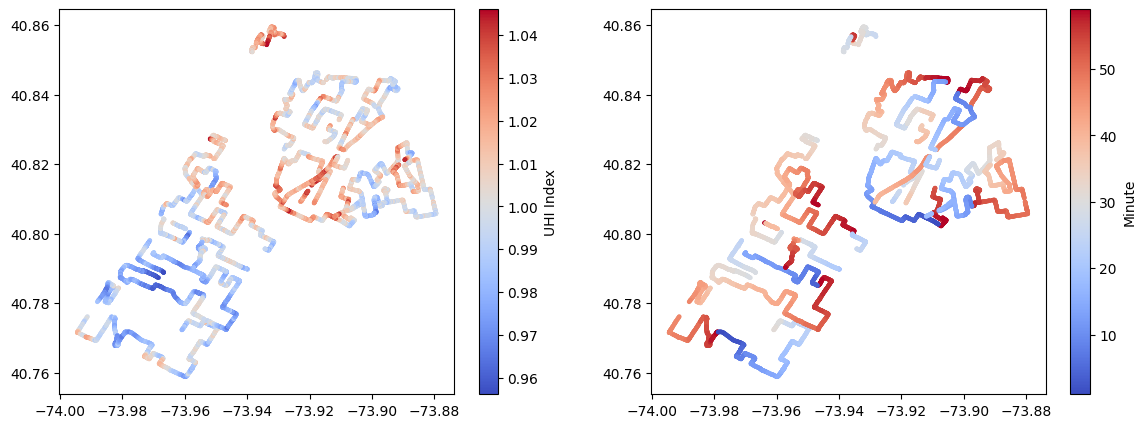

In [7]:
fig, (ax,ay) = plt.subplots(ncols=2, figsize=(14, 5))

sc1 = ax.scatter(df_training['Longitude'], df_training['Latitude'], c = df_training["UHI Index"], s = 5, cmap='coolwarm')
_ = plt.colorbar(sc1, ax=ax, label = "UHI Index")
sc2 = ay.scatter(df_training['Longitude'], df_training['Latitude'], c = df_training["datetime"].dt.minute, s = 5, cmap='coolwarm')
_ = plt.colorbar(sc2, ax=ay, label = "Minute")

-0.050115783644440665
-0.05011578364444067


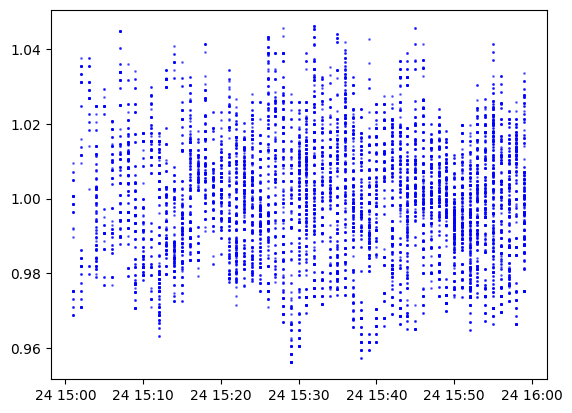

In [8]:
print(df_training["UHI Index"].corr(df_training["datetime"].dt.minute))
print(df_training["datetime"].dt.minute.corr(df_training["UHI Index"]))
_ = plt.plot(df_training["datetime"], df_training["UHI Index"], "ob", ms = 1, alpha = 0.5)

In [9]:
df_training["geometry"] = [Point(x, y) for x, y in zip(df_training["Longitude"], df_training["Latitude"])]
df_training["geometry"].duplicated().value_counts()

,count
geometry,
False,11229


**No hay puntos iguales!**

## 3. Meteorological data

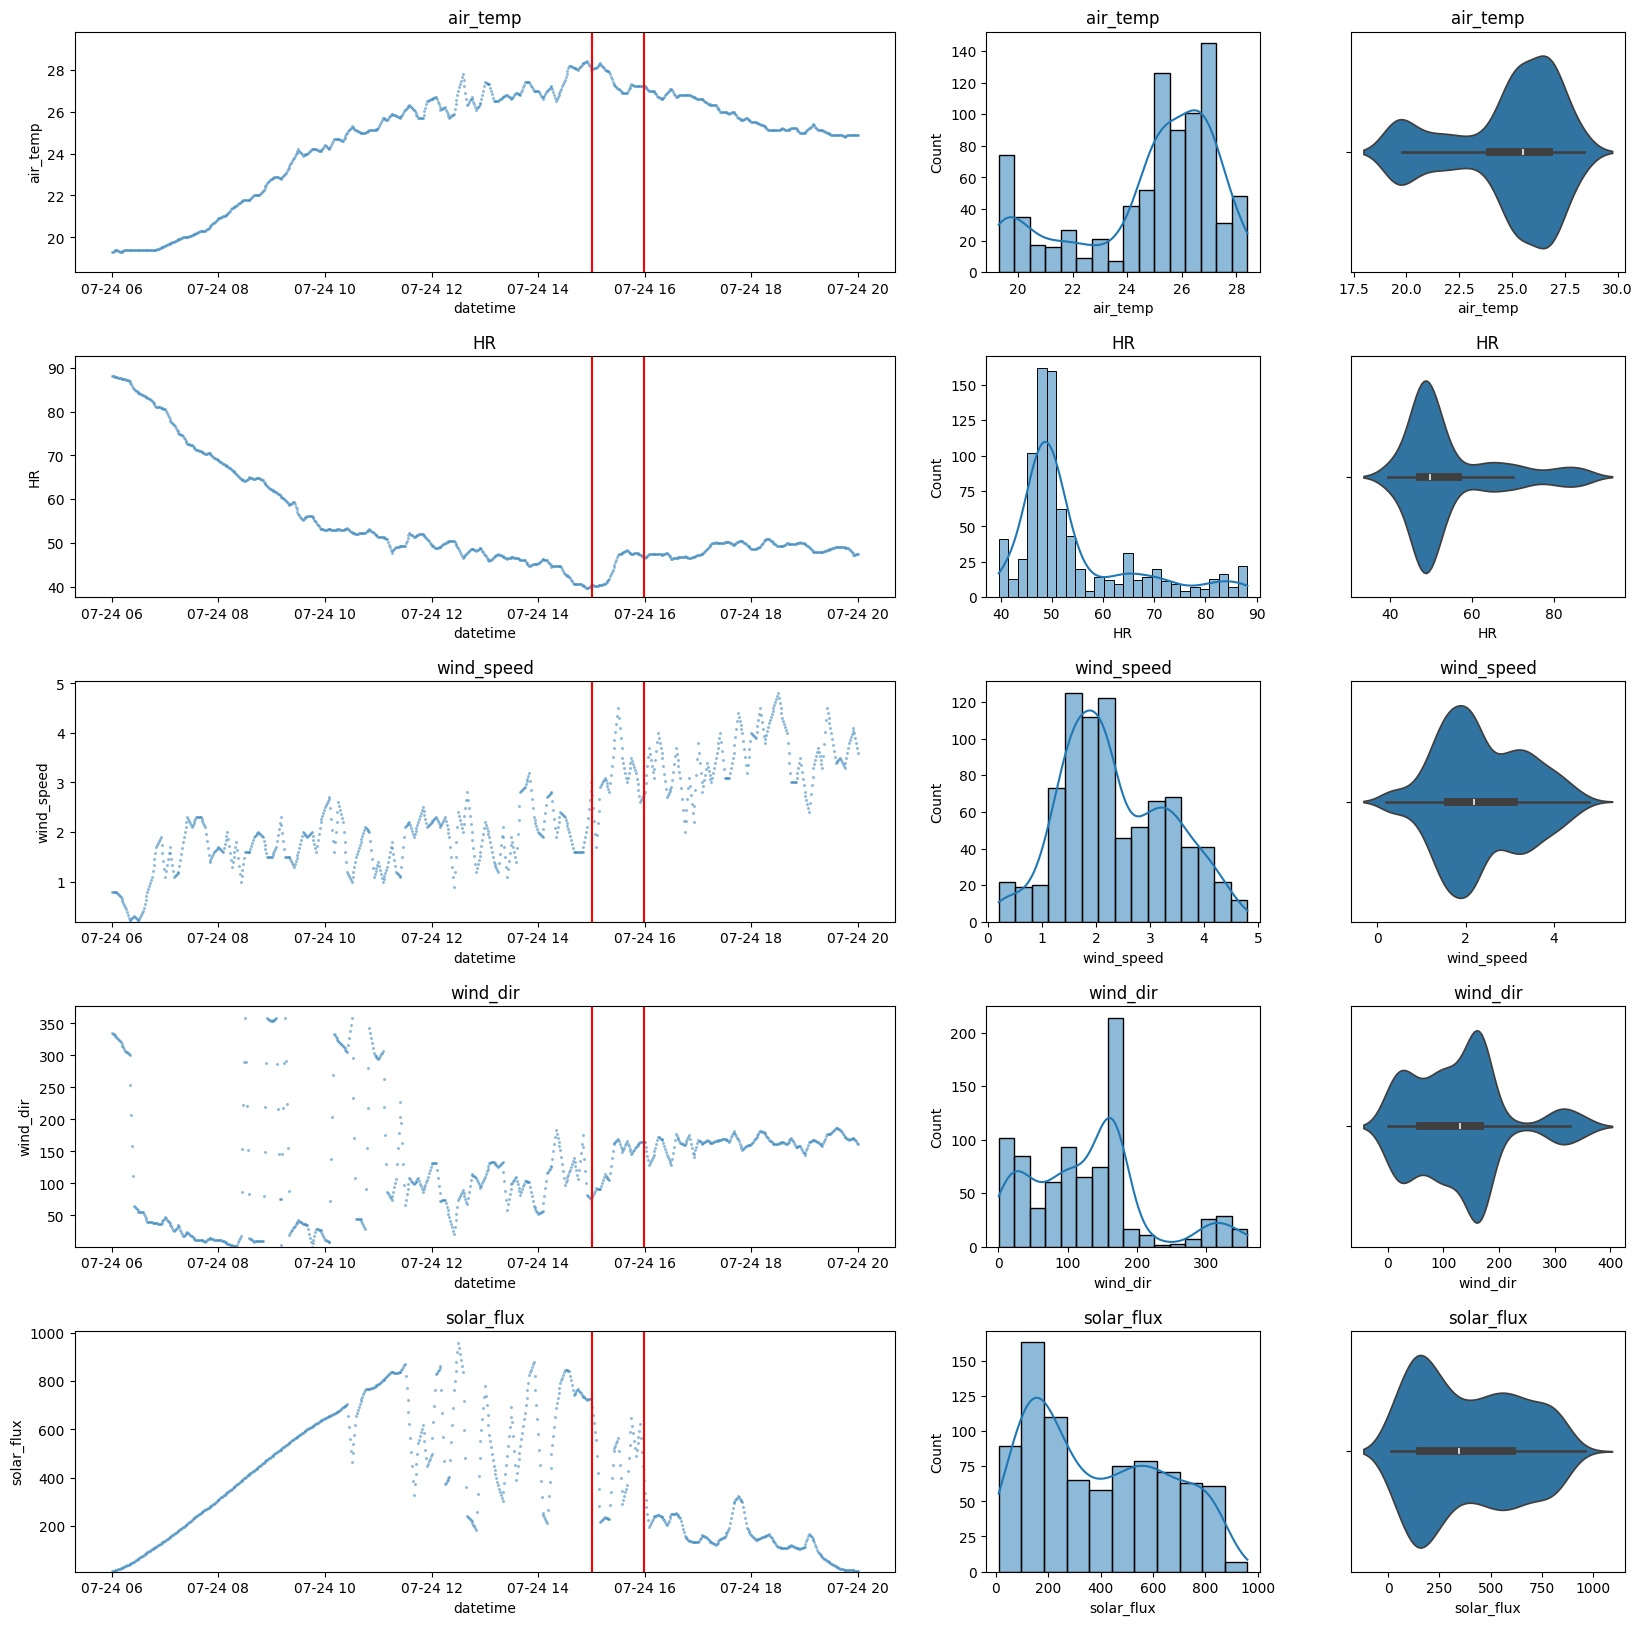

In [10]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize=(20, 20), gridspec_kw={"hspace":0.35}, width_ratios=[3, 1, 1])

sub_data = df_Bronx
for i, col in enumerate(sub_data.columns[1:-4]):
    sns.scatterplot(data=sub_data, x="datetime", y=col, ax=ax[i,0], alpha=0.5, s=5)
    ax[i,0].vlines(df_training["datetime"].min(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].vlines(df_training["datetime"].max(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].set_title(col)
    ax[i,0].set_ylim(sub_data[col].min()*0.95, sub_data[col].max()*1.05)
    sns.histplot(sub_data[col], ax=ax[i,1], kde=True)
    ax[i,1].set_title(col)
    sns.violinplot(data=sub_data, x=col, ax=ax[i,2])
    ax[i,2].set_title(col)

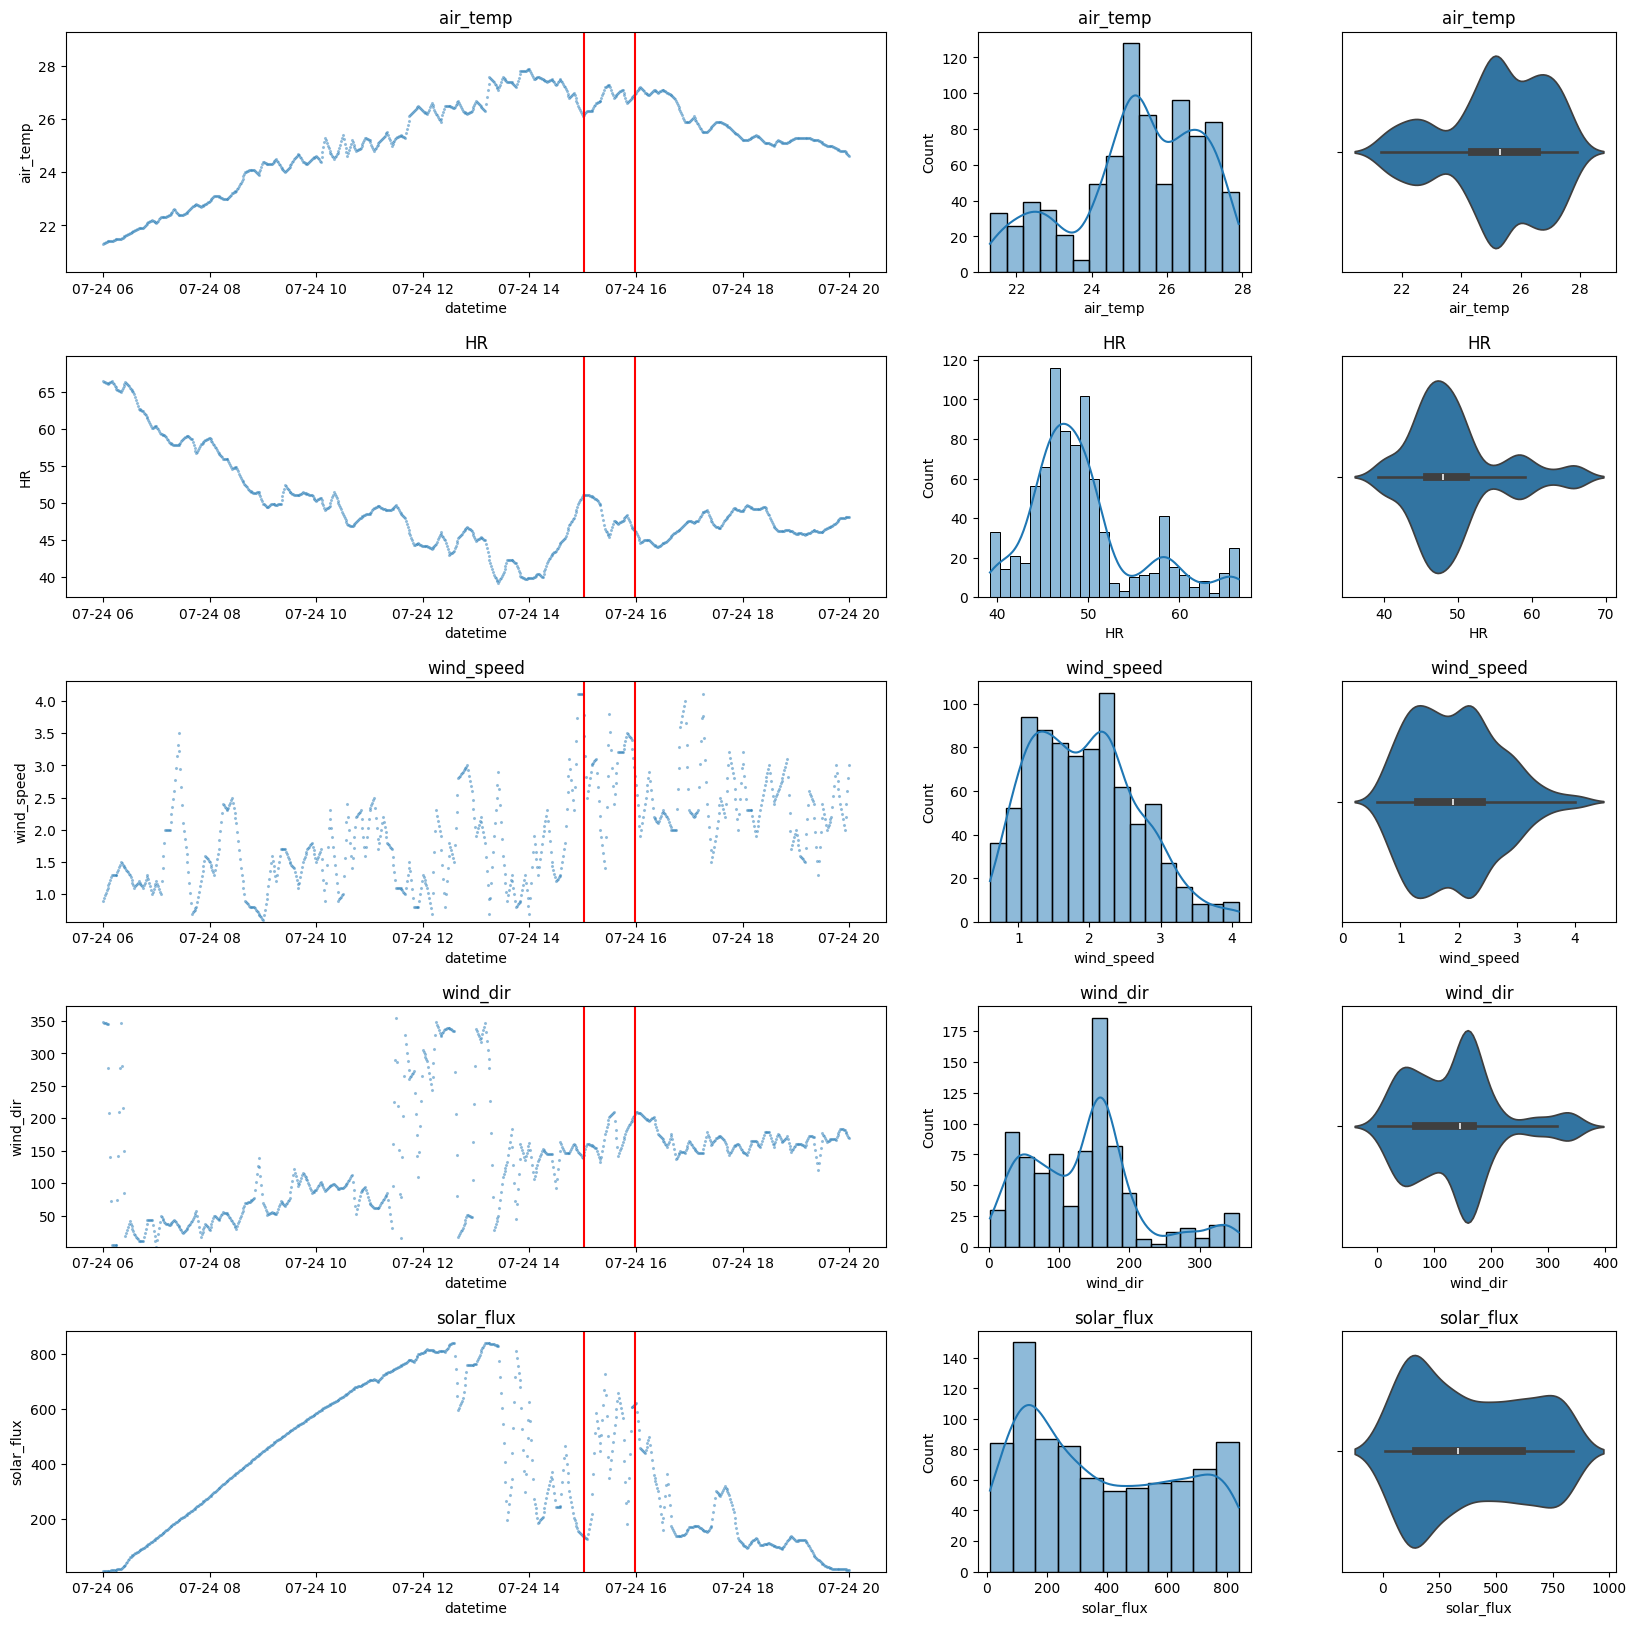

In [11]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize=(20, 20), gridspec_kw={"hspace":0.35}, width_ratios=[3, 1, 1])

sub_data = df_Manhattan
for i, col in enumerate(sub_data.columns[1:-4]):
    sns.scatterplot(data=sub_data, x="datetime", y=col, ax=ax[i,0], alpha=0.5, s=5)
    ax[i,0].vlines(df_training["datetime"].min(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].vlines(df_training["datetime"].max(), sub_data[col].min()*0.9, sub_data[col].max()*1.1, color='r', linestyle='-')
    ax[i,0].set_title(col)
    ax[i,0].set_ylim(sub_data[col].min()*0.95, sub_data[col].max()*1.05)
    sns.histplot(sub_data[col], ax=ax[i,1], kde=True)
    ax[i,1].set_title(col)
    sns.violinplot(data=sub_data, x=col, ax=ax[i,2])
    ax[i,2].set_title(col)

In [12]:
mask_data           = (df_Bronx["datetime"] >= df_training["datetime"].min()) & (df_Bronx["datetime"] <= df_training["datetime"].max())
df_Bronx_masked     = df_Bronx[mask_data]
df_Manhattan_masked = df_Manhattan[mask_data]
df_meteo            = pd.concat([df_Bronx, df_Manhattan], axis=0).reset_index(drop=True)
df_meteo_masked     = pd.concat([df_Bronx_masked, df_Manhattan_masked], axis=0).reset_index(drop=True)
df_meteo_masked.head()

,datetime,air_temp,HR,wind_speed,wind_dir,solar_flux,Latitude,Longitude,Altitude,Place
0,2021-07-24 15:01:00,28.020,40.280,2.740,78.400,691.600,40.872,-73.894,57.500,Bronx
1,2021-07-24 15:02:00,28.040,40.260,2.480,81.800,658.200,40.872,-73.894,57.500,Bronx
2,2021-07-24 15:03:00,28.060,40.240,2.220,85.200,624.800,40.872,-73.894,57.500,Bronx
3,2021-07-24 15:04:00,28.080,40.220,1.960,88.600,591.400,40.872,-73.894,57.500,Bronx
4,2021-07-24 15:05:00,28.100,40.200,1.700,92.000,558.000,40.872,-73.894,57.500,Bronx


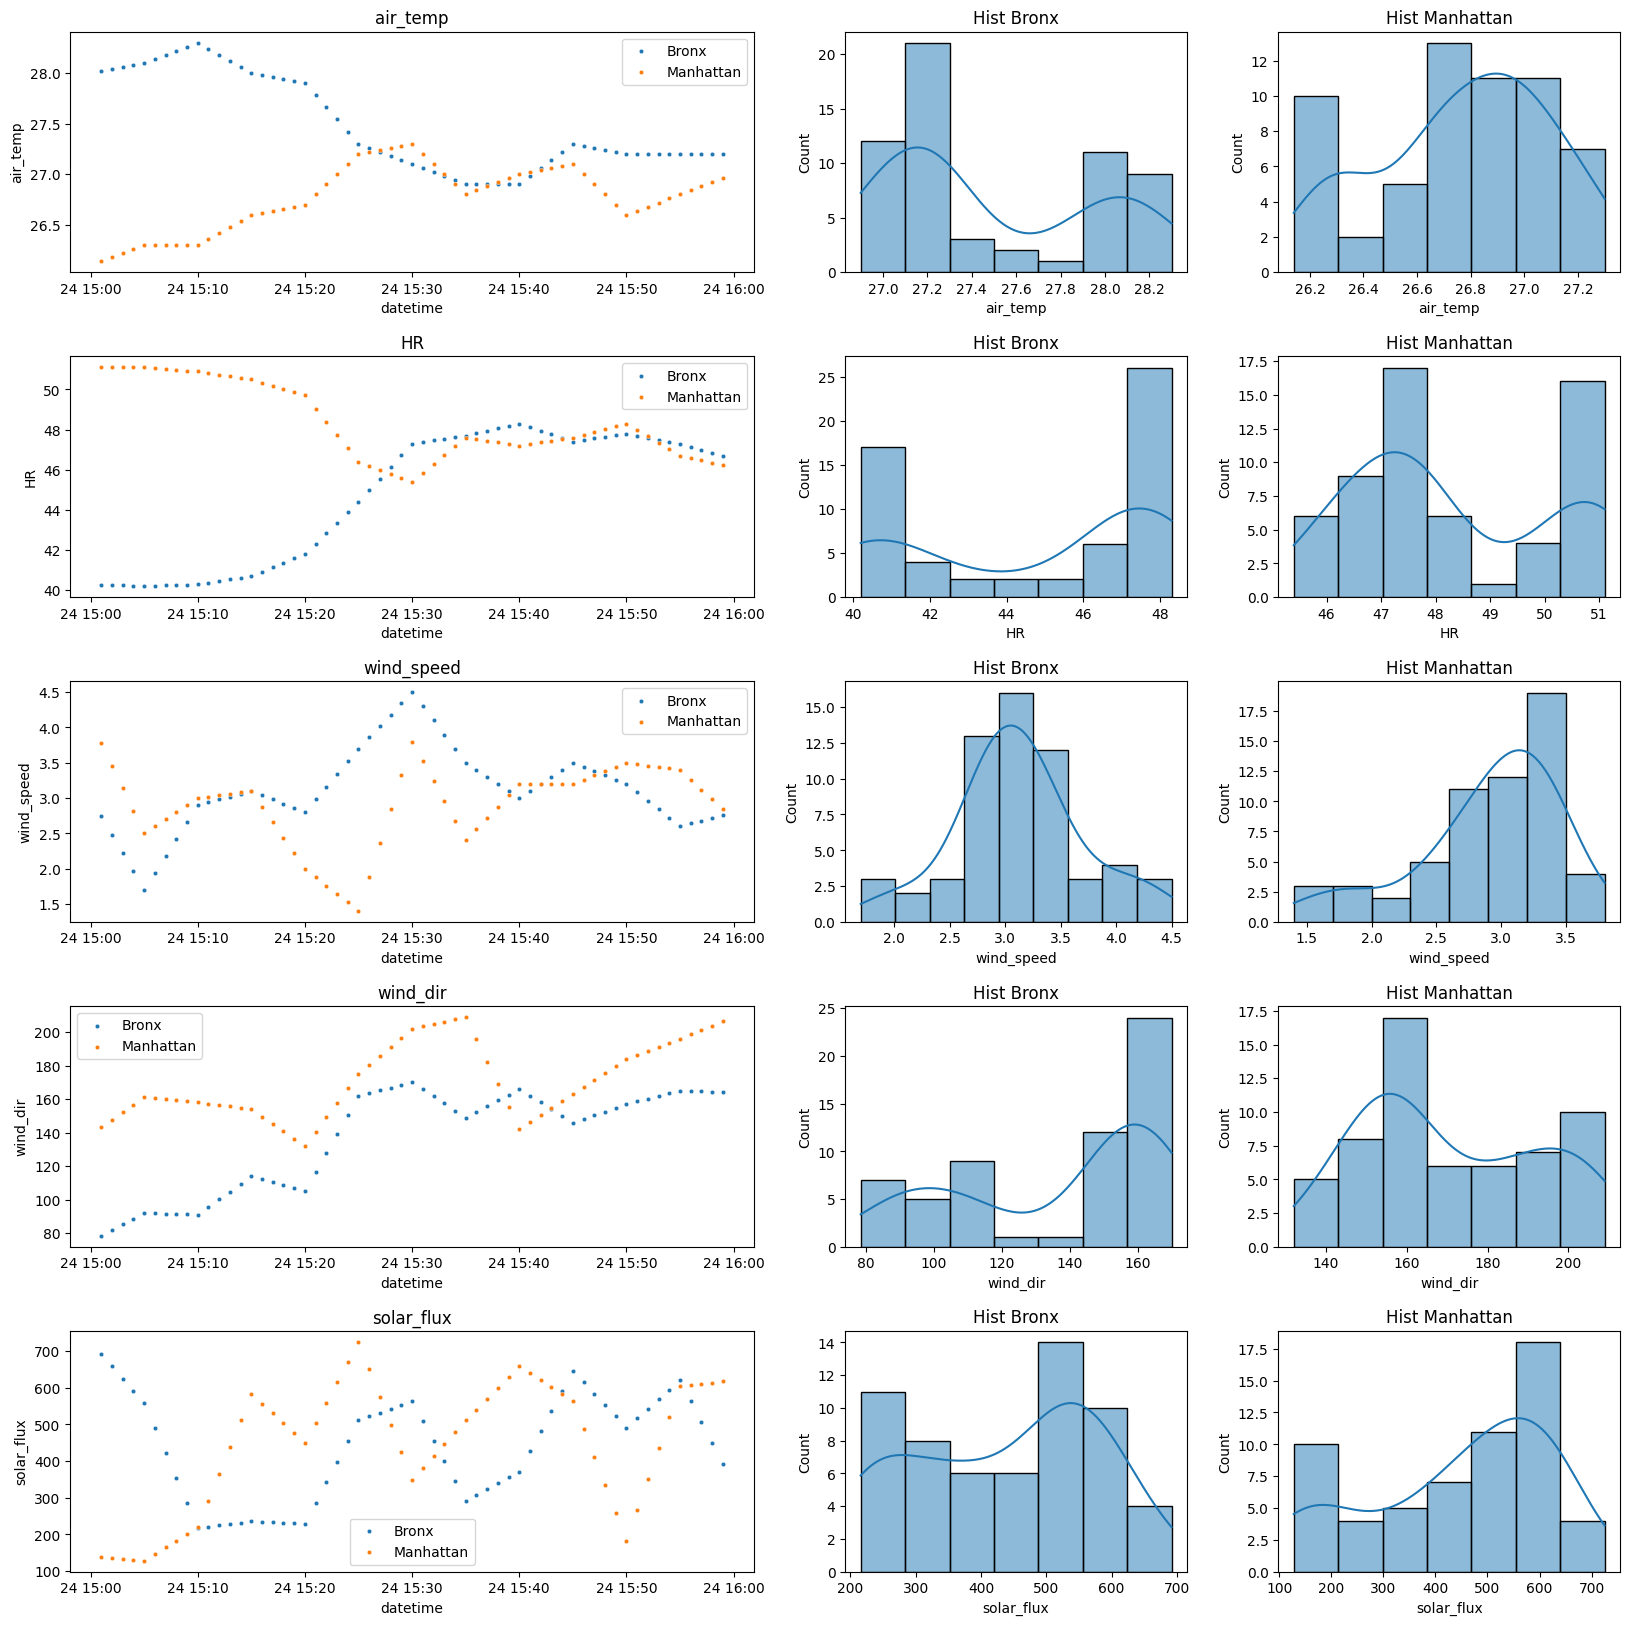

In [13]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize=(20, 20), gridspec_kw={"hspace":0.35}, width_ratios=[2, 1, 1])

for i, col in enumerate(df_Bronx_masked.columns[1:-4]):
    sns.scatterplot(data=df_Bronx_masked, x="datetime", y=col, ax=ax[i,0], s=10, label = "Bronx")
    sns.scatterplot(data=df_Manhattan_masked, x="datetime", y=col, ax=ax[i,0], s=10, label = "Manhattan")
    ax[i,0].set_title(col)
    sns.histplot(df_Bronx_masked[col], ax=ax[i,1], kde=True)
    ax[i,1].set_title("Hist Bronx")
    sns.histplot(df_Manhattan_masked[col], ax=ax[i,2], kde=True)
    ax[i,2].set_title("Hist Manhattan")

## 4. Meteorological and training data

In [14]:
from geopy.distance import geodesic

# Define las coordenadas de los dos puntos
punto1 = (    df_Bronx_masked["Latitude"].unique()[0],     df_Bronx_masked["Longitude"].unique()[0])  # Bronx
punto2 = (df_Manhattan_masked["Latitude"].unique()[0], df_Manhattan_masked["Longitude"].unique()[0]) # Manhattan

# Calcula la distancia usando la función geodesic
distancia = geodesic(punto1, punto2).kilometers
print(f"La distancia entre los dos puntos es: {distancia} kilómetros")

distancias_Bronx      = []
distancias_Manhattan  = []

for geometry in df_training["geometry"]:
    punto3 = (geometry.y, geometry.x)
    distancias_Bronx.append(geodesic(punto1, punto3).kilometers)
    distancias_Manhattan.append(geodesic(punto2, punto3).kilometers)

df_training["distancia_Bronx"]      = distancias_Bronx
df_training["distancia_Manhattan"]  = distancias_Manhattan
df_training["distancia_Bronx"]      = 1 - (df_training["distancia_Bronx"] / df_training["distancia_Bronx"].max())
df_training["distancia_Manhattan"]  = 1 - (df_training["distancia_Manhattan"] / df_training["distancia_Manhattan"].max())

df_training["air_temp"] = 0
df_training["HR"] = 0
df_training["wind_speed"] = 0
df_training["wind_dir"] = 0
df_training["solar_flux"] = 0

def relation_values(var, loc, bronx, manhattan, subdf_date):
    value = (bronx[var].values * df_training.loc[loc, "distancia_Bronx"]) + (manhattan[var].values * df_training.loc[loc, "distancia_Manhattan"])
    value = value / (df_training.loc[loc, "distancia_Bronx"] + df_training.loc[loc, "distancia_Manhattan"])
    return value

for date in tqdm(np.sort(df_training["datetime"].unique()), total=len(df_training["datetime"].unique()), desc="Mapping dates"):
    df_date = df_training.loc[df_training["datetime"] == date]
    bronx = df_Bronx_masked.loc[df_Bronx_masked["datetime"] == date]
    manhattan = df_Manhattan_masked.loc[df_Manhattan_masked["datetime"] == date]
    for subdf_date in df_date.iterrows():
      loc = (df_training["Latitude"] == subdf_date[1]["Latitude"]) & (df_training["Longitude"] == subdf_date[1]["Longitude"]) & (df_training["datetime"] == date)
      df_training.loc[loc, "air_temp"] = relation_values("air_temp", loc, bronx, manhattan, subdf_date)
      df_training.loc[loc, "HR"] = relation_values("HR", loc, bronx, manhattan, subdf_date)
      df_training.loc[loc, "wind_speed"] = relation_values("wind_speed", loc, bronx, manhattan, subdf_date)
      df_training.loc[loc, "wind_dir"] = relation_values("wind_dir", loc, bronx, manhattan, subdf_date)
      df_training.loc[loc, "solar_flux"] = relation_values("solar_flux", loc, bronx, manhattan, subdf_date)

La distancia entre los dos puntos es: 13.10170692785077 kilómetros


Mapping dates: 100%|██████████| 59/59 [01:59<00:00,  2.02s/it]


In [15]:
df_training.head()

,Longitude,Latitude,datetime,UHI Index,geometry,distancia_Bronx,distancia_Manhattan,air_temp,HR,wind_speed,wind_dir,solar_flux
0,-73.909,40.813,2021-07-24 15:53:00,1.030,POINT (-73.90916667 40.81310667),0.523,0.349,27.008,47.436,3.080,173.567,515.526
1,-73.909,40.813,2021-07-24 15:53:00,1.030,POINT (-73.90918667 40.813045),0.522,0.349,27.008,47.436,3.081,173.586,515.442
2,-73.909,40.813,2021-07-24 15:53:00,1.024,POINT (-73.909215 40.81297833),0.521,0.350,27.007,47.436,3.081,173.607,515.347
3,-73.909,40.813,2021-07-24 15:53:00,1.024,POINT (-73.90924167 40.81290833),0.521,0.351,27.007,47.436,3.081,173.628,515.249
4,-73.909,40.813,2021-07-24 15:53:00,1.022,POINT (-73.90925667 40.812845),0.520,0.351,27.007,47.436,3.082,173.647,515.166


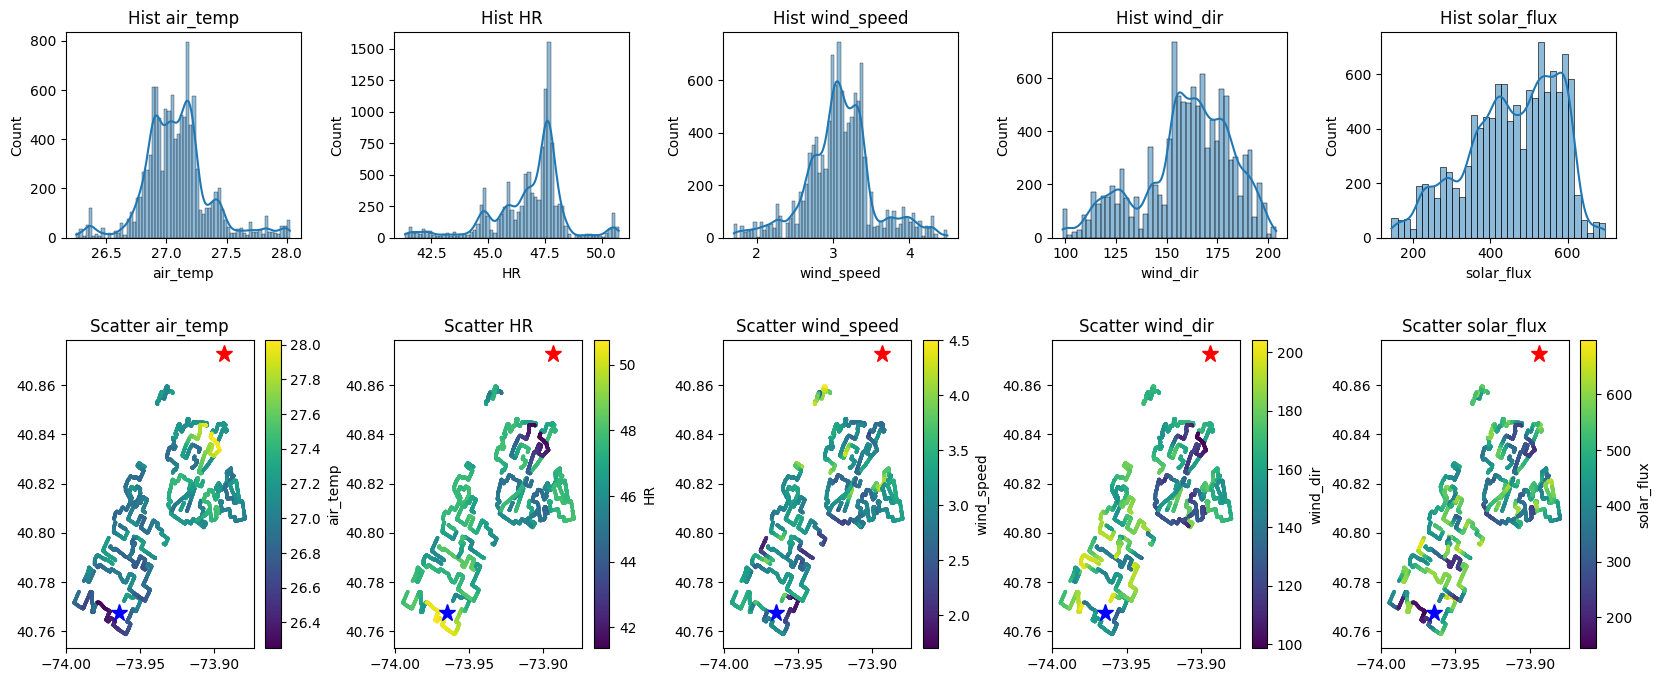

In [16]:
fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize=(20, 8), gridspec_kw={"hspace":0.4, "wspace":0.4}, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1.5])

for i, col in enumerate(df_training.columns[-5:]):
    sns.histplot(df_training[col], ax=ax[0,i], kde=True)
    ax[0,i].set_title("Hist "+col)
    sc1 = ax[1,i].scatter(df_training['Longitude'], df_training['Latitude'], c = df_training[col], s = 2.5)
    ax[1,i].set_title("Scatter "+col)
    ax[1,i].plot(punto1[1], punto1[0], '*', color='red', markersize=12.5, label = "Bronx")
    ax[1,i].plot(punto2[1], punto2[0], '*', color='blue', markersize=12.5, label = "Manhattan")
    _ = plt.colorbar(sc1, ax=ax[1,i], label = col)

## 5. Meteorological and validation data

In [17]:
df_validation["geometry"] = [Point(x, y) for x, y in zip(df_validation["Longitude"], df_validation["Latitude"])]
df_validation["geometry"].duplicated().value_counts()

,count
geometry,
False,1040


In [18]:
from geopy.distance import geodesic

# Define las coordenadas de los dos puntos
punto1 = (    df_Bronx_masked["Latitude"].unique()[0],     df_Bronx_masked["Longitude"].unique()[0])  # Bronx
punto2 = (df_Manhattan_masked["Latitude"].unique()[0], df_Manhattan_masked["Longitude"].unique()[0]) # Manhattan

# Calcula la distancia usando la función geodesic
distancia = geodesic(punto1, punto2).kilometers
print(f"La distancia entre los dos puntos es: {distancia} kilómetros")

distancias_Bronx_val      = []
distancias_Manhattan_val  = []

for geometry in df_validation["geometry"]:
    punto3 = (geometry.y, geometry.x)
    distancias_Bronx_val.append(geodesic(punto1, punto3).kilometers)
    distancias_Manhattan_val.append(geodesic(punto2, punto3).kilometers)

df_validation["distancia_Bronx"]      = distancias_Bronx_val
df_validation["distancia_Manhattan"]  = distancias_Manhattan_val
df_validation["distancia_Bronx"]      = 1 - (df_validation["distancia_Bronx"] / df_validation["distancia_Bronx"].max())
df_validation["distancia_Manhattan"]  = 1 - (df_validation["distancia_Manhattan"] / df_validation["distancia_Manhattan"].max())

df_validation["air_temp"] = 0
df_validation["HR"] = 0
df_validation["wind_speed"] = 0
df_validation["wind_dir"] = 0
df_validation["solar_flux"] = 0

np.random.seed(42)  # Reemplaza 42 con cualquier número entero que desees

def relation_values_val(var, loc, bronx, manhattan, subdf, df):
    bronx      = np.sort(bronx[var])
    bronx_mask = bronx[(bronx <= np.quantile(bronx, 0.25)) | (bronx >= np.quantile(bronx, 0.75))]
    manhattan  = np.sort(manhattan[var])
    manhattan_mask = manhattan[(manhattan <= np.quantile(manhattan, 0.25)) | (manhattan >= np.quantile(manhattan, 0.75))]

    value = (np.random.choice(bronx_mask) * df.loc[loc, "distancia_Bronx"]) + (np.random.choice(manhattan_mask) * df.loc[loc, "distancia_Manhattan"])
    value = value / (df.loc[loc, "distancia_Bronx"] + df.loc[loc, "distancia_Manhattan"])
    return value

for subdf in tqdm(df_validation.iterrows(), total = len(df_validation), desc="Mapping validation data"):
    loc = (df_validation["Latitude"] == subdf[1]["Latitude"]) & (df_validation["Longitude"] == subdf[1]["Longitude"])
    df_validation.loc[loc, "air_temp"]    = relation_values_val("air_temp", loc, bronx, manhattan, subdf, df_validation)
    df_validation.loc[loc, "HR"]          = relation_values_val("HR", loc, bronx, manhattan, subdf, df_validation)
    df_validation.loc[loc, "wind_speed"]  = relation_values_val("wind_speed", loc, bronx, manhattan, subdf, df_validation)
    df_validation.loc[loc, "wind_dir"]    = relation_values_val("wind_dir", loc, bronx, manhattan, subdf, df_validation)
    df_validation.loc[loc, "solar_flux"]  = relation_values_val("solar_flux", loc, bronx, manhattan, subdf, df_validation)

La distancia entre los dos puntos es: 13.10170692785077 kilómetros


Mapping validation data: 100%|██████████| 1040/1040 [00:14<00:00, 70.50it/s]


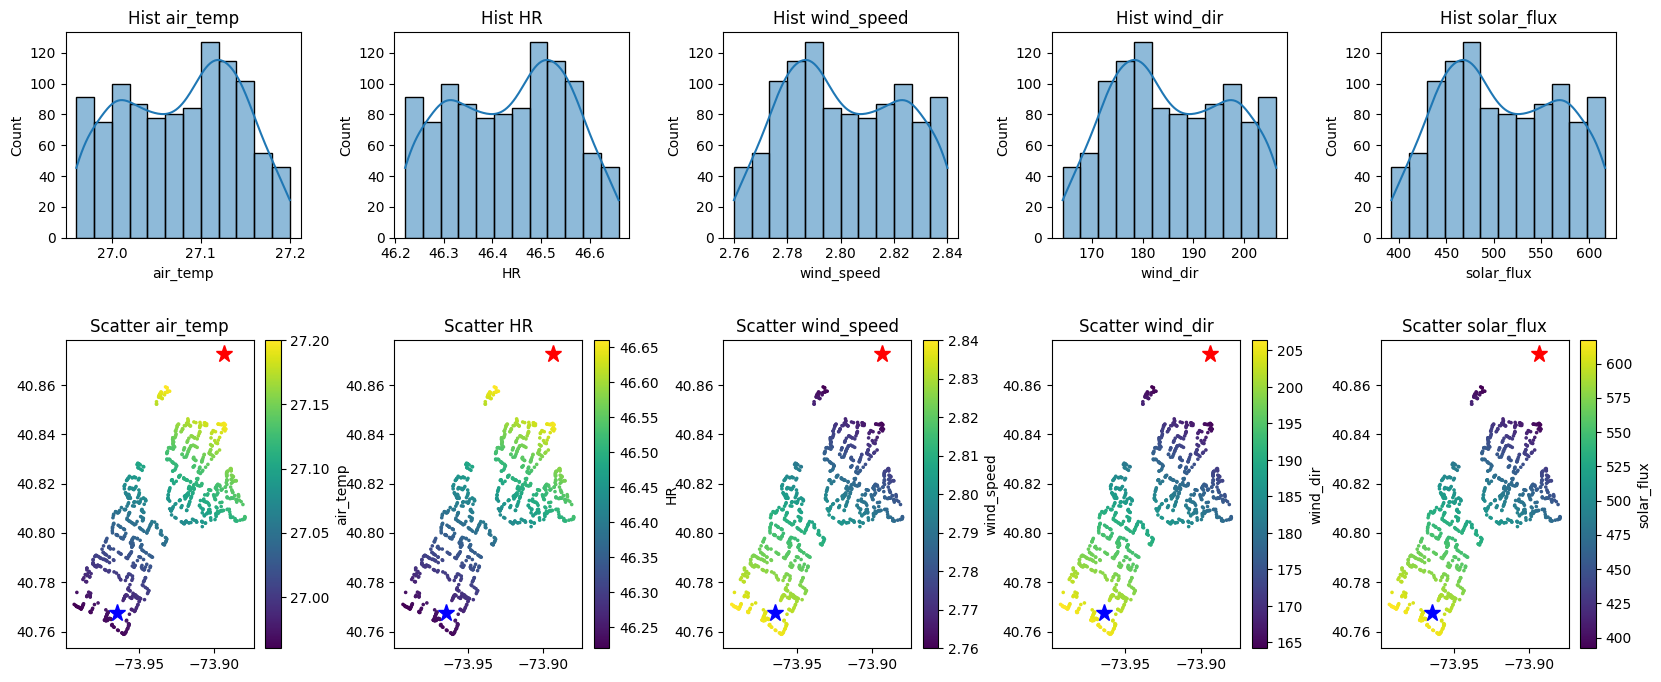

In [19]:
fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize=(20, 8), gridspec_kw={"hspace":0.4, "wspace":0.4}, width_ratios=[1, 1, 1, 1, 1], height_ratios=[1, 1.5])

for i, col in enumerate(df_validation.columns[-5:]):
    sns.histplot(df_validation[col], ax=ax[0,i], kde=True)
    ax[0,i].set_title("Hist "+col)
    sc1 = ax[1,i].scatter(df_validation['Longitude'], df_validation['Latitude'], c = df_validation[col], s = 2.5)
    ax[1,i].set_title("Scatter "+col)
    ax[1,i].plot(punto1[1], punto1[0], '*', color='red', markersize=12.5, label = "Bronx")
    ax[1,i].plot(punto2[1], punto2[0], '*', color='blue', markersize=12.5, label = "Manhattan")
    _ = plt.colorbar(sc1, ax=ax[1,i], label = col)

## Extract information from raster data

In [ ]:
raster

In [20]:
latitudes, longitudes = df_training['Latitude'].values, df_training['Longitude'].values

Band_values = {}
# Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
for i, text_band in enumerate(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']):
    Band_values_all = []
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values Sentinel Band: "+text_band):
        Band_value_point = raster_S2.sel(x=lon, y=lat, band=i, method="nearest").values
        Band_values_all.append(Band_value_point)
    Band_values[text_band] = Band_values_all

Band_values_all = []
for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values Landsat"):
    Band_value_point = raster_LST.sel(x=lon, y=lat, band=1, method="nearest").values
    Band_values_all.append(Band_value_point)
Band_values["LST"] = Band_values_all

# Create a DataFrame to store the band values
result_training = pd.DataFrame.from_dict(Band_values).astype(np.float16)

result_training_concat = pd.concat([df_training, result_training], axis = 1)
result_training_concat["NDVI"]      = (result_training_concat["B08"] - result_training_concat["B04"]) / (result_training_concat["B08"] + result_training_concat["B04"]).replace([np.inf, -np.inf], np.nan)
result_training_concat["NDBI"]      = (result_training_concat["B11"] - result_training_concat["B08"]) / (result_training_concat["B11"] + result_training_concat["B08"]).replace([np.inf, -np.inf], np.nan)
result_training_concat["NDWI"]      = (result_training_concat["B03"] - result_training_concat["B08"]) / (result_training_concat["B03"] + result_training_concat["B08"]).replace([np.inf, -np.inf], np.nan)
result_training_concat["SWIR_Diff"] = (result_training_concat["B11"] - result_training_concat["B12"]).replace([np.inf, -np.inf], np.nan)    # Diferencia SWIR

Mapping values Landsat: 100%|██████████| 11229/11229 [00:15<00:00, 735.90it/s]


In [21]:
result_training_concat.isna().sum()

,0
Longitude,0
Latitude,0
datetime,0
UHI Index,0
geometry,0
distancia_Bronx,0
distancia_Manhattan,0
air_temp,0
HR,0
wind_speed,0


In [22]:
result_training_concat.to_csv("training_data.csv", index=False)

In [23]:
latitudes_val, longitudes_val = df_validation['Latitude'].values, df_validation['Longitude'].values

Band_validation = {}
# Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
for i, text_band in enumerate(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']):
    Band_validation_all = []
    for lat, lon in tqdm(zip(latitudes_val, longitudes_val), total=len(latitudes_val), desc="Mapping values Sentinel Band: "+text_band):
        Band_value_point = raster_S2.sel(x=lon, y=lat, band=i, method="nearest").values
        Band_validation_all.append(Band_value_point)
    Band_validation[text_band] = Band_validation_all

Band_validation_all = []
for lat, lon in tqdm(zip(latitudes_val, longitudes_val), total=len(latitudes_val), desc="Mapping values Landsat"):
    Band_value_point = raster_LST.sel(x=lon, y=lat, band=1, method="nearest").values
    Band_validation_all.append(Band_value_point)
Band_validation["LST"] = Band_validation_all

# Create a DataFrame to store the band values
result_validation = pd.DataFrame.from_dict(Band_validation).astype(np.float16)

result_validation_concat = pd.concat([df_validation, result_validation], axis = 1)

result_validation_concat["NDVI"]      = (result_validation_concat["B08"] - result_validation_concat["B04"]) / (result_validation_concat["B08"] + result_validation_concat["B04"]).replace([np.inf, -np.inf], np.nan)
result_validation_concat["NDBI"]      = (result_validation_concat["B11"] - result_validation_concat["B08"]) / (result_validation_concat["B11"] + result_validation_concat["B08"]).replace([np.inf, -np.inf], np.nan)
result_validation_concat["NDWI"]      = (result_validation_concat["B03"] - result_validation_concat["B08"]) / (result_validation_concat["B03"] + result_validation_concat["B08"]).replace([np.inf, -np.inf], np.nan)
result_validation_concat["SWIR_Diff"] = (result_validation_concat["B11"] - result_validation_concat["B12"]).replace([np.inf, -np.inf], np.nan)    # Diferencia SWIR

Mapping values Landsat: 100%|██████████| 1040/1040 [00:01<00:00, 726.96it/s]


In [24]:
result_validation_concat.isna().sum()

,0
Longitude,0
Latitude,0
UHI Index,1040
geometry,0
distancia_Bronx,0
distancia_Manhattan,0
air_temp,0
HR,0
wind_speed,0
wind_dir,0


In [25]:
result_validation_concat.to_csv("validation_data.csv", index=False)